In [1]:
from typing import Optional
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
from matplotlib.backends.backend_pdf import PdfPages
from src.train.plots import Line
from src.processes.observables import Observable
import warnings

In [2]:
plt.rc("font", family="serif", size=16)
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

COLORS = [f"C{i}" for i in range(10)]
RECO_COLOR = COLORS[0]
HARD_COLOR = COLORS[1]
AFF_INN_COLOR = COLORS[2]
RQS_INN_COLOR = COLORS[3]
CFM_COLOR = COLORS[4]
P_DIDI_COLOR = COLORS[5]
UP_DIDI_COLOR = COLORS[6]
SB_COLOR = COLORS[7]
OMNI_COLOR = COLORS[8]

## Histogram functions

In [3]:
def hist_plot(
    pdf: PdfPages,
    lines: list[Line],
    bins: np.ndarray,
    observable: Observable,
    show_ratios: bool = True,
    title: Optional[str] = None,
    no_scale: bool = False,
    yscale: Optional[str] = None,
    show: bool = False,
    rect = None,
    ylabel = "normalized",
    xlim = None,
    ylim = None,
    legend_kwargs = {},
    legend_callback = None,
):
    """
    Makes a single histogram plot, used for the observable histograms and clustering
    histograms.
    Args:
        pdf: Multipage PDF object
        lines: List of line objects describing the histograms
        bins: Numpy array with the bin boundaries
        show_ratios: If True, show a panel with ratios
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        n_panels = 1 + int(show_ratios)
        fig, axs = plt.subplots(
            n_panels,
            1,
            sharex=True,
            figsize=(6, 4.5),
            gridspec_kw={"height_ratios": (3, 2, 1)[:n_panels], "hspace": 0.00},
        )
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
        if n_panels == 1:
            axs = [axs]

        for line in lines:
            if line.vline:
                axs[0].axvline(line.y, label=line.label, color=line.color)
                continue
            integral = np.sum((bins[1:] - bins[:-1]) * line.y)
            scale = 1 / integral if integral != 0.0 else 1.0
            if line.y_ref is not None:
                ref_integral = np.sum((bins[1:] - bins[:-1]) * line.y_ref)
                ref_scale = 1 / ref_integral if ref_integral != 0.0 else 1.0
            if no_scale:
                scale = 1.
                ref_scale = 1.

            hist_line(
                axs[0],
                bins,
                line.y * scale,
                line.y_err * scale if line.y_err is not None else None,
                label=line.label,
                color=line.color,
                fill=line.fill,
                linestyle=line.linestyle
            )

            if line.y_ref is not None:
                ratio = (line.y * scale) / (line.y_ref * ref_scale)
                ratio_isnan = np.isnan(ratio)
                if line.y_err is not None:
                    if len(line.y_err.shape) == 2:
                        ratio_err = (line.y_err * scale) / (line.y_ref * ref_scale)
                        ratio_err[:, ratio_isnan] = 0.0
                    else:
                        ratio_err = np.sqrt((line.y_err / line.y) ** 2)
                        ratio_err[ratio_isnan] = 0.0
                else:
                    ratio_err = None
                ratio[ratio_isnan] = 1.0
                hist_line(
                    axs[1], bins, ratio, ratio_err, label=None, color=line.color
                )

        if legend_callback is not None:
            legend_callback(axs)
        axs[0].legend(frameon=False, **legend_kwargs)
        axs[0].set_ylabel(ylabel)
        axs[0].set_yscale(observable.yscale if yscale is None else yscale)
        if ylim is not None:
            axs[0].set_ylim(*ylim)
        #if title is not None:
        #    self.corner_text(axs[0], title, "left", "top")

        if show_ratios:
            axs[1].set_ylabel(r"$\frac{\mathrm{Model}}{\mathrm{Truth}}$")
            axs[1].set_yticks([0.95, 1, 1.05])
            axs[1].set_ylim([0.9, 1.1])
            axs[1].axhline(y=1, c="black", ls="--", lw=0.7)
            axs[1].axhline(y=1.1, c="black", ls="dotted", lw=0.5)
            axs[1].axhline(y=0.9, c="black", ls="dotted", lw=0.5)

        unit = "" if observable.unit is None else f" [{observable.unit}]"
        axs[-1].set_xlabel(f"${{{observable.tex_label}}}${unit}")
        axs[-1].set_xscale(observable.xscale)
        if xlim is None:
            axs[-1].set_xlim(bins[0], bins[-1])
        else:
            axs[-1].set_xlim(*xlim)

        plt.savefig(pdf, format="pdf")
        if show:
            plt.show()
        plt.close()

def hist_line(
    ax: mpl.axes.Axes,
    bins: np.ndarray,
    y: np.ndarray,
    y_err: np.ndarray,
    label: str,
    color: str,
    linestyle: str = "solid",
    fill: bool = False,
):
    """
    Plot a stepped line for a histogram, optionally with error bars.
    Args:
        ax: Matplotlib Axes
        bins: Numpy array with bin boundaries
        y: Y values for the bins
        y_err: Y errors for the bins
        label: Label of the line
        color: Color of the line
        linestyle: line style
        fill: Filled histogram
    """

    dup_last = lambda a: np.append(a, a[-1])

    if fill:
        ax.fill_between(
            bins, dup_last(y), label=label, facecolor=color, step="post", alpha=0.2
        )
    else:
        ax.step(
            bins,
            dup_last(y),
            label=label,
            color=color,
            linewidth=1.0,
            where="post",
            ls=linestyle,
        )
    if y_err is not None:
        if len(y_err.shape) == 2:
            y_low = y_err[0]
            y_high = y_err[1]
        else:
            y_low = y - y_err
            y_high = y + y_err

        ax.step(
            bins,
            dup_last(y_high),
            color=color,
            alpha=0.5,
            linewidth=0.5,
            where="post",
        )
        ax.step(
            bins,
            dup_last(y_low),
            color=color,
            alpha=0.5,
            linewidth=0.5,
            where="post",
        )
        ax.fill_between(
            bins,
            dup_last(y_low),
            dup_last(y_high),
            facecolor=color,
            alpha=0.3,
            step="post",
        )

## Pythia Observables Plots

In [4]:
with open("plots/observables_comparison.pkl", "rb") as f:
    data_inn1 = pickle.load(f)
    
with open("plots/observables.pkl", "rb") as f:
    data_inn2 = pickle.load(f)
    


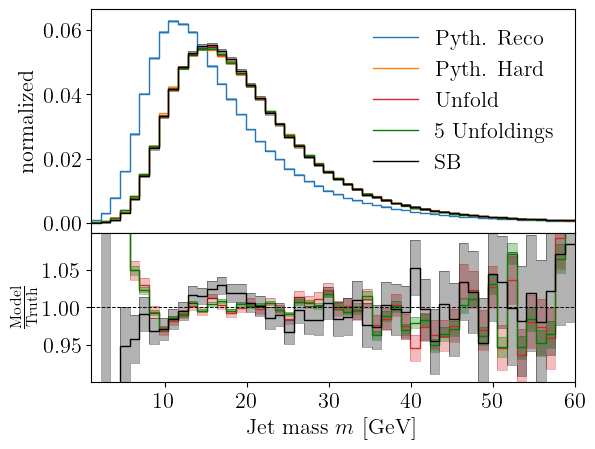

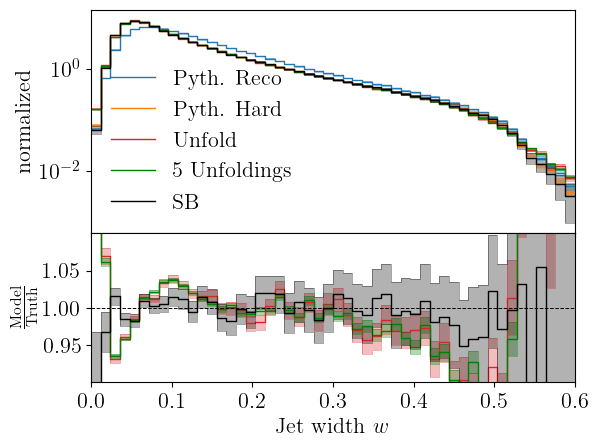

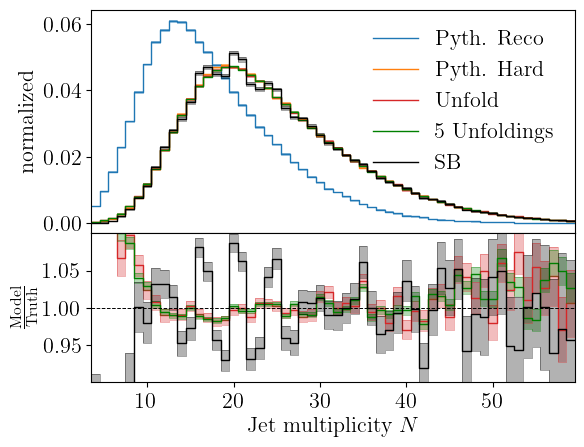

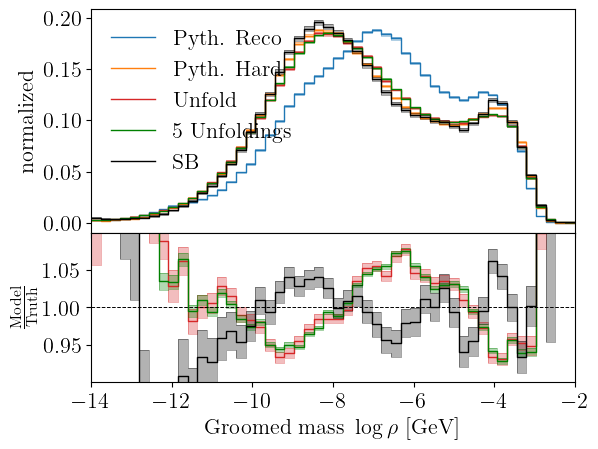

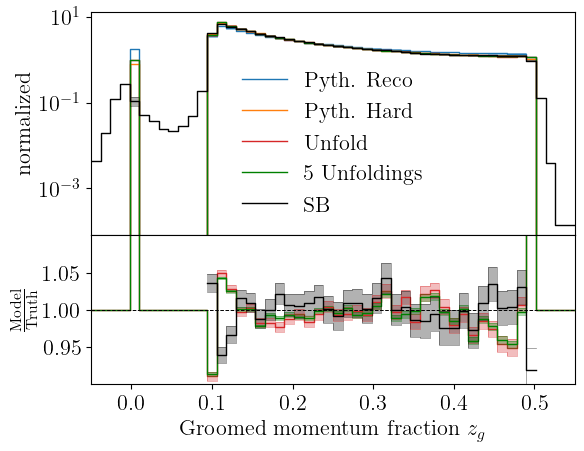

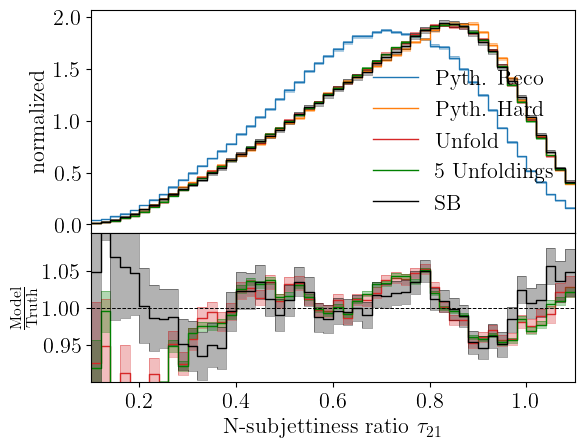

In [5]:
with PdfPages("plots/observables_pythia.pdf") as pp:
    for obs_data_inn, obs_data_inn2 in zip(data_inn1, data_inn2):

        obs = obs_data_inn["obs"]
        bins = obs_data_inn["bins"]
        
        line_reco = obs_data_inn["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Pyth. Reco"
        
        line_hard = obs_data_inn["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Pyth. Hard"

        line_inn = obs_data_inn["lines"][2]
        line_inn.color = RQS_INN_COLOR
        #line_inn.label = "INN"
        
        line_inn2 = obs_data_inn["lines"][3]
        line_inn2.color = "green"
        #line_inn2.label = "INN2"
        
        
        line_inn3 = obs_data_inn["lines"][4]
        line_inn3.color = "black"

        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_inn, line_inn2, line_inn3],
            bins=bins,
            observable=obs,
            show_ratios=True,
            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("lower left" if obs.tex_label == r"E_{j_1}" or obs.tex_label == r"p_{T,j_1}" or obs.tex_label == "\Delta \phi_{j_1,j_2}" else "best")},
        )

In [6]:
for obs_data_inn, obs_data_inn2 in zip(data_inn1, data_inn2):

    obs_inn1 = obs_data_inn["obs"]
    obs_inn2 = obs_data_inn2["obs"]
    
    print("-----------------------------------")
    print(f"Observable {obs_inn1.tex_label}")
    print(f"INN1 EMD {obs_inn1.emd_mean} pm {obs_inn1.emd_std} ; TriDist {obs_inn1.triangle_mean} pm {obs_inn1.triangle_std}")
    print(f"INN2 EMD {obs_inn2.emd_mean} pm {obs_inn2.emd_std} ; TriDist {obs_inn2.triangle_mean} pm {obs_inn2.triangle_std}")
    print("-----------------------------------")


-----------------------------------
Observable \text{Jet mass } m


AttributeError: 'Observable' object has no attribute 'emd_mean'

## Herwig Observables Plots

In [ ]:
with open("plots/observables_analysis_inn1.pkl", "rb") as f:
    data_inn1 = pickle.load(f)
    
with open("plots/observables_analysis_inn2.pkl", "rb") as f:
    data_inn2 = pickle.load(f)

In [ ]:
with PdfPages("plots/observables_herwig.pdf") as pp:
    for obs_data_inn, obs_data_inn2 in zip(data_inn1, data_inn2):

        obs = obs_data_inn["obs"]
        bins = obs_data_inn["bins"]
        
        line_reco = obs_data_inn["lines"][0]
        line_reco.color = RECO_COLOR
        line_reco.label = "Herw. Reco"
        
        line_hard = obs_data_inn["lines"][1]
        line_hard.color = HARD_COLOR
        line_hard.label = "Herg. Hard"

        line_inn = obs_data_inn["lines"][2]
        line_inn.color = RQS_INN_COLOR
        line_inn.label = "INN"
        
        line_inn2 = obs_data_inn2["lines"][2]
        line_inn2.color = "green"
        line_inn2.label = "INN2"

        hist_plot(
            pdf=pp,
            lines=[line_reco, line_hard, line_inn, line_inn2],
            bins=bins,
            observable=obs,
            show_ratios=True,
            show=True,
            rect=(0.08,0.08,0.99,0.99), # left, bottom, right, top
            legend_kwargs={"loc": ("lower left" if obs.tex_label == r"E_{j_1}" or obs.tex_label == r"p_{T,j_1}" or obs.tex_label == "\Delta \phi_{j_1,j_2}" else "best")},
        )

In [ ]:
for obs_data_inn, obs_data_inn2 in zip(data_inn1, data_inn2):

    obs_inn1 = obs_data_inn["obs"]
    obs_inn2 = obs_data_inn2["obs"]
    
    print("-----------------------------------")
    print(f"Observable {obs_inn1.tex_label}")
    print(f"INN1 EMD {obs_inn1.emd_mean} pm {obs_inn1.emd_std} ; TriDist {obs_inn1.triangle_mean} pm {obs_inn1.triangle_std}")
    print(f"INN2 EMD {obs_inn2.emd_mean} pm {obs_inn2.emd_std} ; TriDist {obs_inn2.triangle_mean} pm {obs_inn2.triangle_std}")
    print("-----------------------------------")


In [ ]:
p = "/Users/huetsch/Desktop/GenerativeUnfolding/output/save_shit/20240122_143811_inn_det/metrics.pkl"
with open(p, "rb") as f:
    metrics = pickle.load(f)

In [ ]:
metrics[0].metrics

In [ ]:
for obs_data_inn, obs_data_inn2 in zip(data_inn1, data_inn2):

    obs_inn1 = obs_data_inn["obs"]
    obs_inn2 = obs_data_inn2["obs"]
    print(obs_inn2.metrics)
    break